# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# from sklearn.datasets import load_boston
# boston = load_boston()
# X = boston["data"]
# y = boston["target"]


data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.2959024480813

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

$\sum \frac{1}{n}(x_i - \overline{x})^2 = \overline{x^2} - (\overline{x})^2$

In [6]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """

    n = X.shape[0]
    sum_preds = np.zeros(n)
    sum_sq_preds = np.zeros(n)
    num_preds = np.zeros(n)
    loss = 0
    for i in range(num_runs):
        sample_idxs = np.random.choice(np.arange(n), n)
        out_of_bag_idxs = np.setdiff1d(np.arange(n), sample_idxs)
        
        regressor.fit(X[sample_idxs], y[sample_idxs])
        preds = regressor.predict(X[out_of_bag_idxs])
        sum_preds[out_of_bag_idxs] += preds
        sum_sq_preds[out_of_bag_idxs] += preds**2
        num_preds[out_of_bag_idxs] += 1

        loss += np.sum((preds - y[out_of_bag_idxs])**2)
        
    bias = np.mean((sum_preds / num_preds - y)**2)
    variance =  np.mean(sum_sq_preds / num_preds - (sum_preds / num_preds)**2)

    loss /= np.sum(num_preds)
    return bias, variance, loss

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [13]:
compute_biase_variance(LinearRegression(), X, y)


(23.774978656002826, 0.9520958927380274, 24.80637300588479)

In [14]:
compute_biase_variance(DecisionTreeRegressor(), X, y)

(10.222849033051455, 13.199399123464449, 23.495439036061644)

In [15]:
compute_biase_variance(RandomForestRegressor(n_estimators=10), X, y)

(10.63904349463329, 3.352077807702812, 14.041299081441915)

__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

Мы получили, что у **линейной регрессии** почти нулевой разброс, но большое смещение

у **решающего дерева** примерно одинаковые разброс и смещение, но смещение сильно меньше, чем у линрега, а разброс сильно больше

у **случайного леса** смещение сильно меньше, чем у линрега, но примерно такое же, как у решающего дерева (так и должно быть в теории, случайный лес - вариация бэггинга над деревьями, а бэггинг не меняет смещение базового алгоритма), но разброс сильно меньше, чем у решающего дерева (как раз засчет понижения корреляции деревьев разброс уменьшается)

Результаты согласуются!

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

В теории для некоррелированных базовых моделей разброс с бэггингом должен уменьшиться в N=10 раз (по умолчанию в склерне n_estimators=10 у BaggingRegressor).
Однако у линейной регрессии почти нет изменений ни по каким показателям - это связано с тем, что бэггинг на моделях с и так низким смещением эффекта не дает. У решающего дерева разброс действительно уменьшился, но примерно в 4 раза. У случайного леса уменьшился в 2 раза, но у него и так был невыскокий разброс. В целом в силу коррелированоости моделей результаты приемлемы

In [4]:
from sklearn.ensemble import BaggingRegressor

In [9]:
compute_biase_variance(BaggingRegressor(LinearRegression()), X, y)

(23.75627904584677, 1.0613086043582691, 24.784553131458875)

In [10]:
compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y)

(10.683480835808517, 3.3122035116059454, 14.150766206386399)

In [12]:
compute_biase_variance(BaggingRegressor(RandomForestRegressor(n_estimators=10)), X, y)

(11.508325104785186, 1.5281629751735577, 13.162210857423375)

In [17]:
# я не знаю, в чем заключалось задание, поэтому вот второй вариант "бэггинга над тремя моделями"
class Bagging:
    def __init__(self):
        self.linreg = LinearRegression()
        self.tree = DecisionTreeRegressor()
        self.forest = RandomForestRegressor(n_estimators=10)

    def fit(self, X, y):
        self.linreg.fit(X, y)
        self.tree.fit(X, y)
        self.forest.fit(X, y)

    def predict(self, X):
        return np.mean(np.array([self.linreg.predict(X), self.tree.predict(X), self.forest.predict(X)]), axis=0)
    
compute_biase_variance(Bagging(), X, y)

(11.54374930725814, 2.685939303217624, 14.292088037669213)

 В теории для некоррелированных базовых моделей бэггинг должен уменьшить разброс в N=3 раз (количество базовых моделей). Разбросы: линрег 0.9, дерево 13, лес 2, то есть, во-первых, разбросы сильно отличаются, во-вторых, средний разброс (примерно 5) уменьшился с бэггингом в 2 раза. Получается, что теоретическое предположение здесь не выполнено как раз потому, что разбросы базовых моделей очень разные.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [102]:
def plot_predictions(regressor, X, y, ax, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    n = X.shape[0]
    test_idxs = np.random.choice(np.arange(n), num_test_objects)
    train_idxs = np.setdiff1d(np.arange(n), test_idxs)

    n_train = train_idxs.shape[0]
    X_train, y_train = X[train_idxs], y[train_idxs]
    X_test, y_test = X[test_idxs], y[test_idxs]


    for i in range(num_runs):
        sample_idxs = np.random.choice(np.arange(n_train), n_train)
        regressor.fit(X_train[sample_idxs], y_train[sample_idxs])
        preds = regressor.predict(X_test)
        ax.scatter(np.arange(num_test_objects), preds, marker='v')

    ax.scatter(np.arange(num_test_objects), y_test, c='black')
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('test object')
    ax.set_ylabel('prediction / ground truth')

    


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [99]:
num_test_objects = np.random.choice(np.arange(10, X.shape[0]//3), 1)

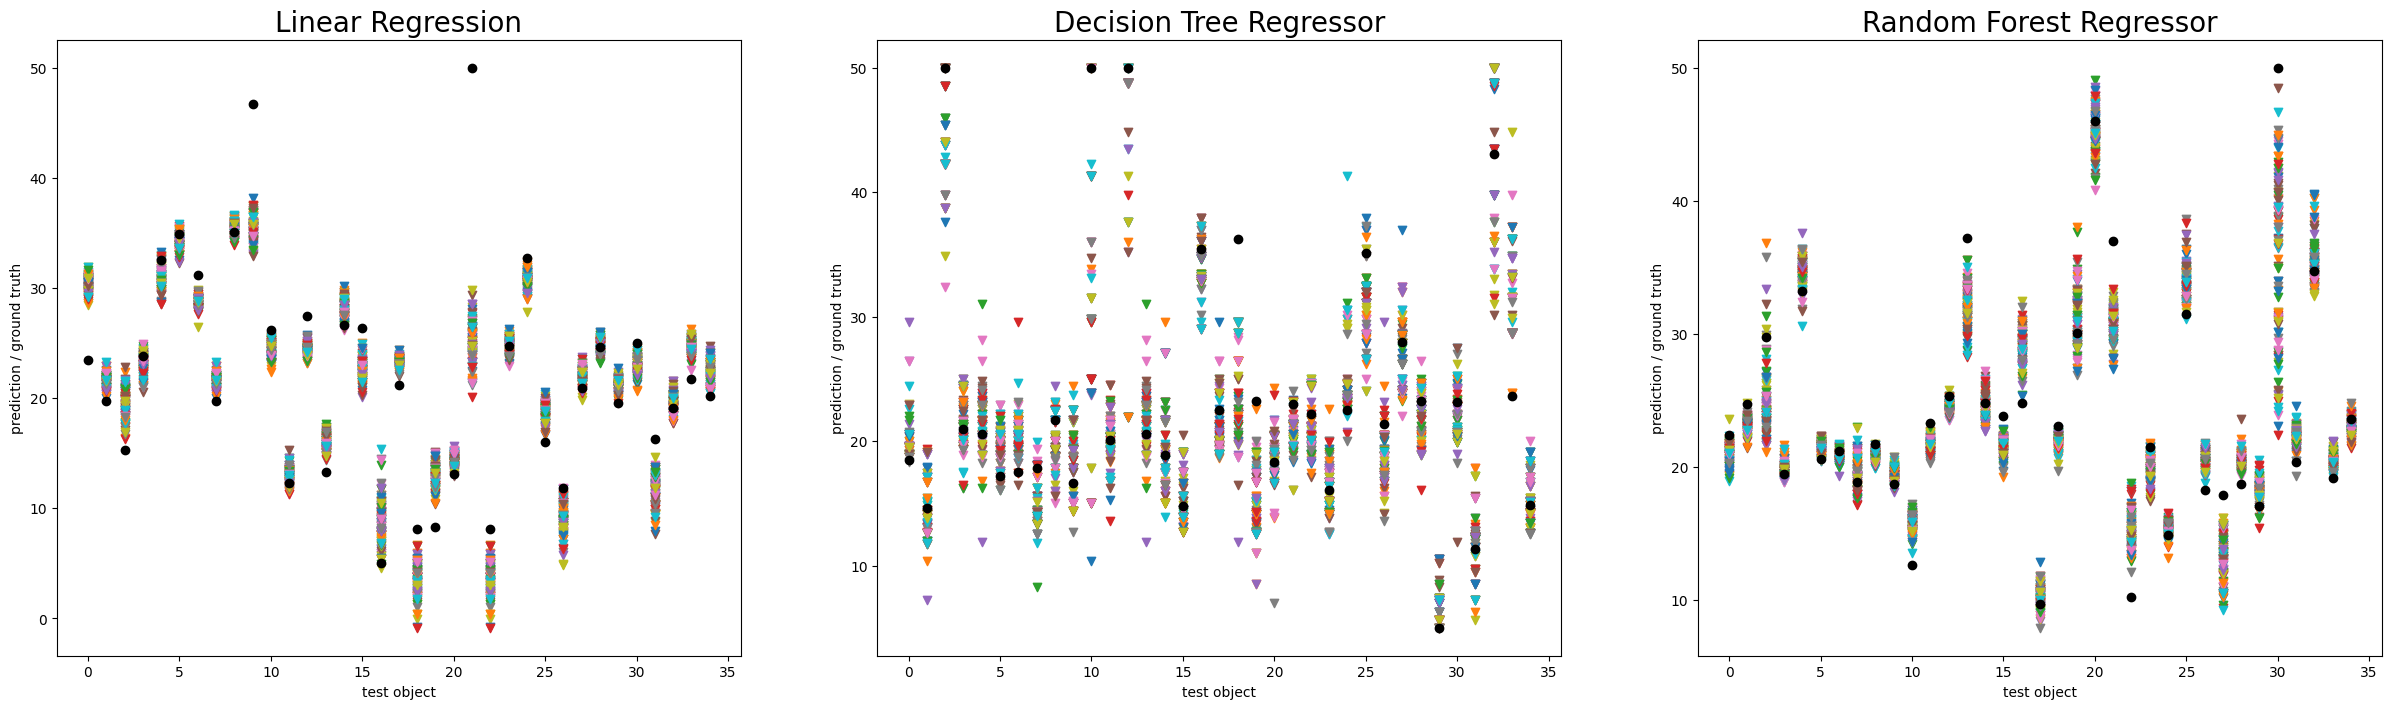

In [103]:
f, ax = plt.subplots(1, 3, figsize=(30, 8))
plot_predictions(LinearRegression(), X, y, ax[0], num_test_objects=num_test_objects, title='Linear Regression')
plot_predictions(DecisionTreeRegressor(), X, y, ax[1], num_test_objects=num_test_objects, title='Decision Tree Regressor')
plot_predictions(RandomForestRegressor(), X, y, ax[2], num_test_objects=num_test_objects, title='Random Forest Regressor')
plt.show()

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

**Линейная регрессия**: в каждом столбике предсказания плотно собрались в одной области, однако эта облась часто далека от верного ответа, то есть разброс маленький, а смещение большое (но не огромное, оно просто почти стабильно есть ненулевое)

**Решающее дерево**: разброс достаточно большой на многих объектах тестовой выборки, поэтому он и в среднем не маленький у модели. Со смещением такая же ситуация, хотя теоретически у деревьев смещение должно быть низкое (ну оно и по графикам явно ниже, чем у линрега)

**Случайный лес**: разброс низкий по таким же соображениям, что и у линрега (по расположению предсказаний в столбце), но смещение заметно ниже, чем у линрега, и как будто на многих объектах прям очень маленькое, т. к. черная точка внутри плотной области столбца.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [104]:
import seaborn as sns

In [115]:

depths = np.arange(1, 10)
features = np.arange(1, X.shape[1])
scores_d = {'bias':[], 'variance':[]}
scores_f = {'bias':[], 'variance':[]}
for md in depths:
    regressor = DecisionTreeRegressor(max_depth=md)
    bias, variance, loss = compute_biase_variance(regressor, X, y)
    scores_d['bias'].append(bias)
    scores_d['variance'].append(variance)

for mf in features:
    regressor = DecisionTreeRegressor(max_features=mf)
    bias, variance, loss = compute_biase_variance(regressor, X, y)
    scores_f['bias'].append(bias)
    scores_f['variance'].append(variance)



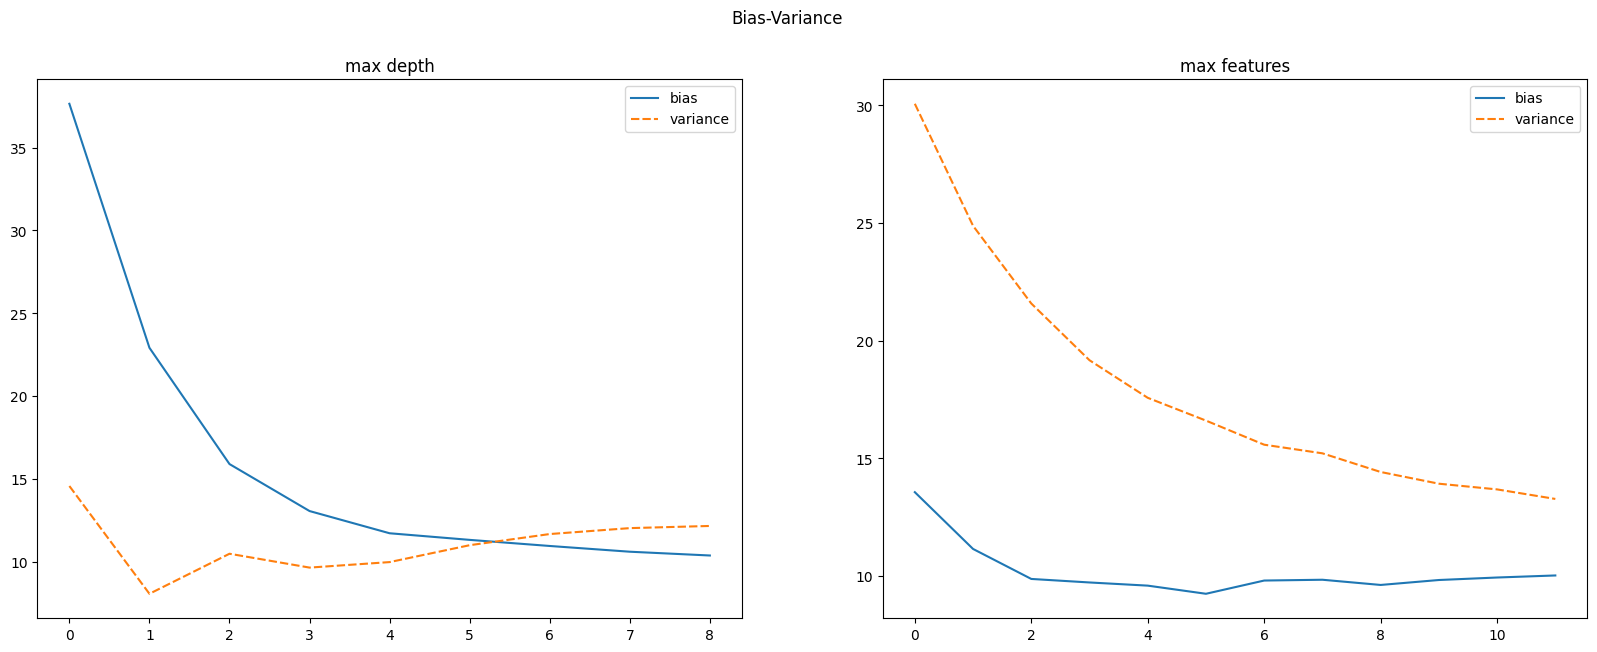

In [116]:
f, ax = plt.subplots(1, 2, figsize=(20, 7))
f.suptitle('Bias-Variance')
ax[0].set_title('max depth')
sns.lineplot(scores_d, ax=ax[0])
ax[1].set_title('max features')
sns.lineplot(scores_f, ax=ax[1])
plt.show()


__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [1]:
import numpy as np 
2**np.arange(1, 10)

array([  2,   4,   8,  16,  32,  64, 128, 256, 512])

In [118]:
from sklearn.ensemble import GradientBoostingRegressor

In [120]:
estims = 2**np.arange(1, 10)
scores_rf = {'bias':[], 'variance':[]}
scores_gb = {'bias':[], 'variance':[]}

for n_estims in estims:
    regressor = RandomForestRegressor(n_estimators=n_estims)
    bias, variance, loss = compute_biase_variance(regressor, X, y, num_runs=100)
    scores_rf['bias'].append(bias)
    scores_rf['variance'].append(variance)

    regressor = GradientBoostingRegressor(n_estimators=n_estims)
    bias, variance, loss = compute_biase_variance(regressor, X, y, num_runs=100)
    scores_gb['bias'].append(bias)
    scores_gb['variance'].append(variance)



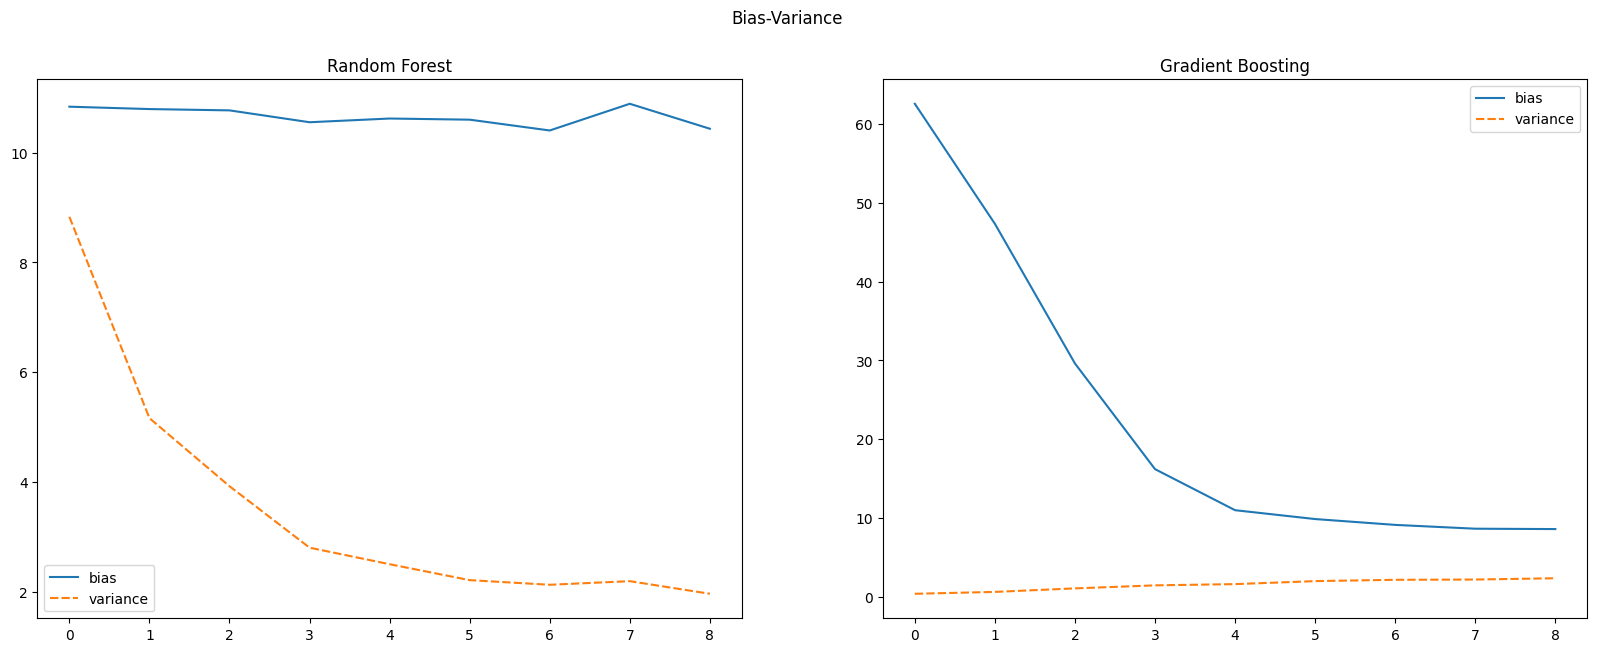

In [121]:
f, ax = plt.subplots(1, 2, figsize=(20, 7))
f.suptitle('Bias-Variance')
ax[0].set_title('Random Forest')
sns.lineplot(scores_rf, ax=ax[0])
ax[1].set_title('Gradient Boosting')
sns.lineplot(scores_gb, ax=ax[1])
plt.show()


__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Решающее дерево:

**max depth** Мы получили оптимальное значение параметра (5-6), так как графики смещения и разброса пересекаются и примерно в там же достиглось бы наименьшее значение ошибки модели. При увеличении глубины дерева до переобучения разброс падает, а смещение растет, а потом наоборот

**max features** При росте количества рассматриваемых для деления выборки признаков разброс и смещение падают, поскольку дерево лучше учится на большем количестве данных, однако если бы признаков было больше (у нас в датасете), в какой то момент показатели начали бы расти и модель переобучилась бы

Случайный лес 

**n_estimators** Смещение почти не меняется, но так и должно быть в случае случайного леса. Разброс убывает при росте количества базовых моделей в силу уменьшения корреляции бутстрапированными выборками и при делении выборки по выборочным признакам

Градиентный бустинг

**n_estimators** От роста итераций бустинга смещение падает, так как каждое следующее дерево обучается на то, чтобы снизить смещение, а разброс не меняется

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__

Праздровали светлый праздник Хануки!
![хагханукасамэах](2023-12-18.jpg)